In [ ]:
pip install pandas scikit-learn


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity



In [ ]:
file_path = '/content/social media influencers - instagram sep-2022.csv'
df = pd.read_csv(file_path)

In [ ]:
def convert_to_millions(value):
    try:
        if 'M' in value:
            return float(value.replace('M', ''))
        else:
            return float(value) / 1_000_000  # if in thousands, convert to millions
    except ValueError:
        return None

In [ ]:
df['Subscribers'] = df['Subscribers'].apply(convert_to_millions)
df['Authentic engagement'] = df['Authentic engagement\n'].apply(convert_to_millions)
df['Engagement average'] = df['Engagement average\r\n'].apply(convert_to_millions)

In [ ]:
df.drop(columns=['Authentic engagement\n', 'Engagement average\r\n'], inplace=True)

In [ ]:
df.dropna(subset=['Subscribers', 'Authentic engagement', 'Engagement average'], inplace=True)

In [ ]:
X = df[['Subscribers', 'Authentic engagement', 'Engagement average']]

In [ ]:
silhouette_scores = []
for n_clusters in range(2, 11):
    cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=n_clusters, random_state=0))])
    cluster_labels = cluster_pipeline.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

optimal_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=optimal_n_clusters, random_state=0))])


In [ ]:
df['cluster'] = cluster_pipeline.fit_predict(X)
print(f"Optimal number of clusters: {optimal_n_clusters}")
print("Silhouette Scores:", silhouette_scores)

Optimal number of clusters: 2
Silhouette Scores: [0.46764720353567124, 0.3105560607166754, 0.24088079663801362, 0.14412699999999737, 0.11912071463783425, -0.09186887362990681, 0.02774820379552326, -0.109809196235595, -0.1364047978101622]


In [ ]:
df['Category_1'] = df['Category_1'].fillna('')
df['Category_2'] = df['Category_2'].fillna('')


In [ ]:
df['combined_categories'] = df['Category_1'] + " " + df['Category_2']


In [ ]:
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(df['combined_categories'])

In [ ]:
similarity = cosine_similarity(tfidf_matrix)

In [ ]:
indices = pd.Series(df.index, index=df['Instagram name']).drop_duplicates()

In [ ]:
def influencer_recommendation(name, similarity=similarity, top_n=5):
    # Get the index of the influencer by name
    index = indices.get(name, None)
    if index is None:
        return "Influencer not found."
    # Only proceed if index is found
    else:
        similarity_scores = list(enumerate(similarity[index]))
        similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
        # Further logic for recommendations
        # ... (rest of your recommendation logic)
        top_indices = [i[0] for i in similarity_scores[1:top_n+1]]  # exclude the influencer themself

        return df['Instagram name'].iloc[top_indices] # Dedented this line to align with the 'else' block

In [ ]:
print("Recommendations for 'kyliejenner':")
print(influencer_recommendation("kyliejenner"))


Recommendations for 'kyliejenner':
9          beyonce
46     harrystyles
54     georginagio
56    haileybieber
62      sadiesink_
Name: Instagram name, dtype: object


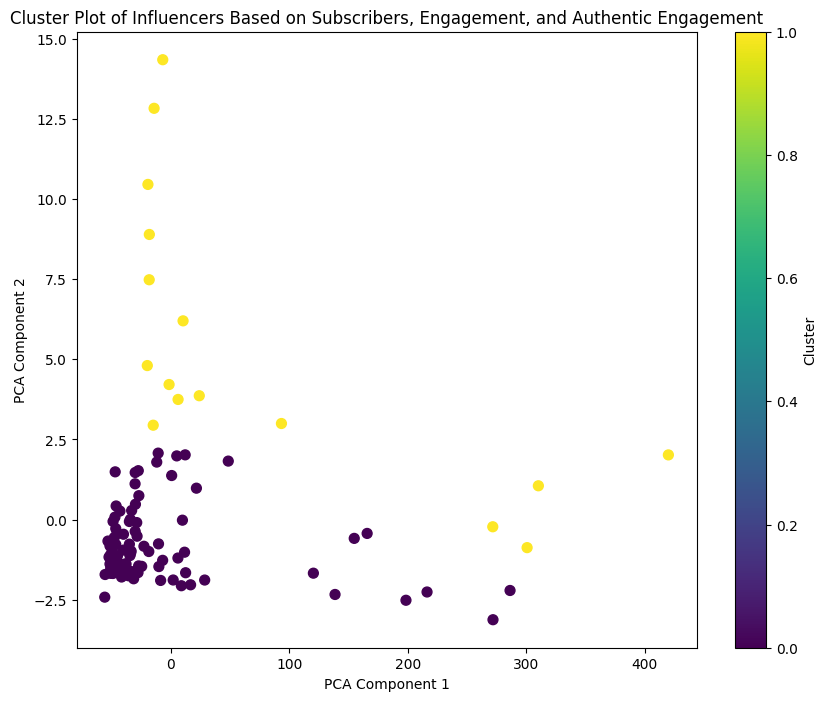

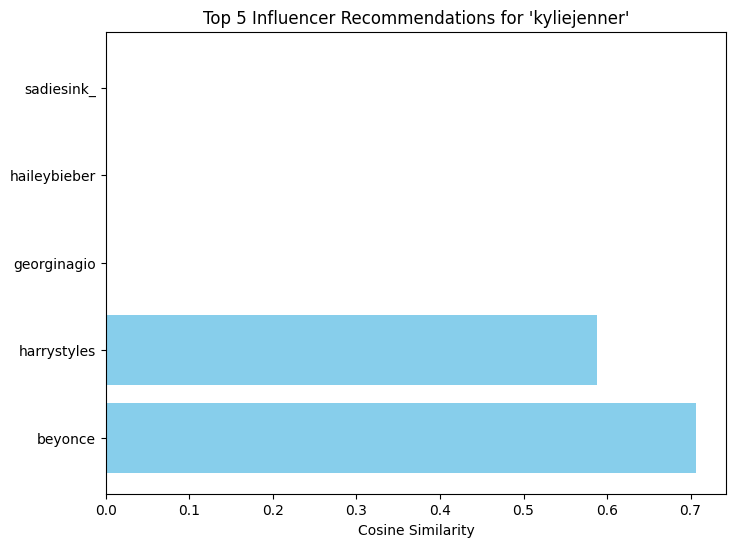

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Visualize Clusters
# Reduce dimensions to 2D for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the clusters with different colors
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', s=50)
plt.title("Cluster Plot of Influencers Based on Subscribers, Engagement, and Authentic Engagement")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

# 2. Visualize Influencer Recommendations
def plot_influencer_recommendations(name, top_n=5):
    recommendations = influencer_recommendation(name, top_n=top_n)

    if isinstance(recommendations, str):  # In case influencer not found
        print(recommendations)
        return

    # Get the similarity scores of the recommended influencers
    indices = [df[df['Instagram name'] == rec].index[0] for rec in recommendations]
    similarity_scores = [similarity[df[df['Instagram name'] == name].index[0], idx] for idx in indices]

    # Plot the similarity scores for top recommendations
    plt.figure(figsize=(8, 6))
    plt.barh(recommendations, similarity_scores, color='skyblue')
    plt.xlabel("Cosine Similarity")
    plt.title(f"Top {top_n} Influencer Recommendations for '{name}'")
    plt.show()

# Test the recommendation and plotting system
plot_influencer_recommendations("kyliejenner", top_n=5)


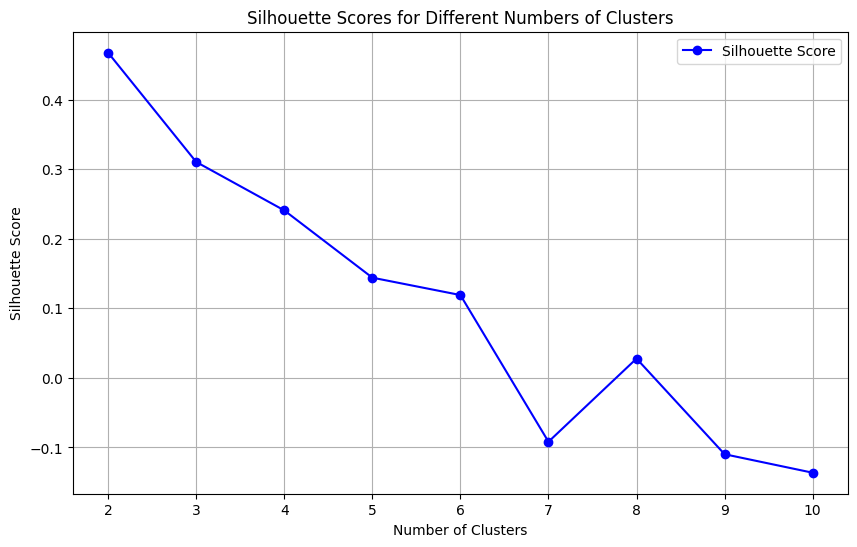

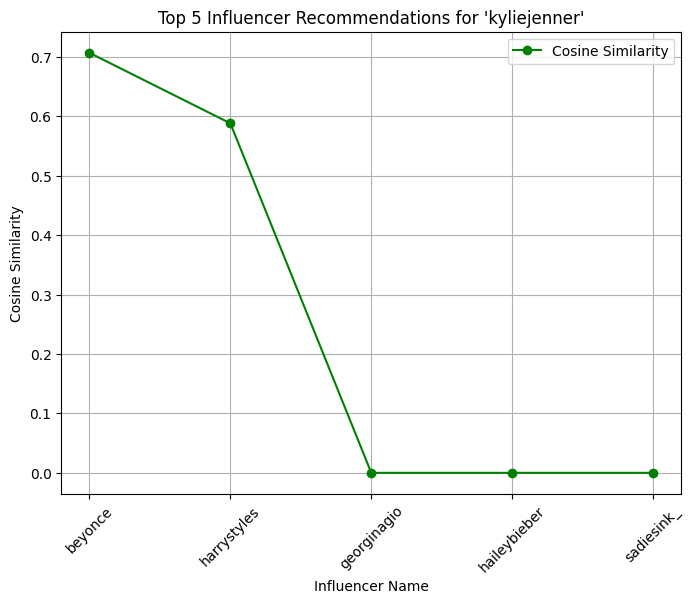

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Line Graph for Silhouette Scores (Optimal Clusters Selection)
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b', label="Silhouette Score")
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, 11, 1))  # Set x-ticks to match the number of clusters tested
plt.grid(True)
plt.legend()
plt.show()

# 2. Line Graph for Influencer Recommendations (Cosine Similarity Scores)
def plot_influencer_recommendations_line_graph(name, top_n=5):
    recommendations = influencer_recommendation(name, top_n=top_n)

    if isinstance(recommendations, str):  # In case influencer not found
        print(recommendations)
        return

    # Get the similarity scores of the recommended influencers
    indices = [df[df['Instagram name'] == rec].index[0] for rec in recommendations]
    similarity_scores = [similarity[df[df['Instagram name'] == name].index[0], idx] for idx in indices]

    # Plot the cosine similarity scores as a line graph
    plt.figure(figsize=(8, 6))
    plt.plot(recommendations, similarity_scores, marker='o', color='g', linestyle='-', label="Cosine Similarity")
    plt.title(f"Top {top_n} Influencer Recommendations for '{name}'")
    plt.xlabel("Influencer Name")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Test the line graph for influencer recommendations
plot_influencer_recommendations_line_graph("kyliejenner", top_n=5)
